# <font color='Goldenrod'>*Yellow*</font><font color=#303030> is the new </font> *black*

## <font color=#303030> Abstract</font>
The creation and propagation of false information has existed since the dawn of time.
Behind these misleading elements are often hidden political or financial intentions, in order to gain credit or make competitors lose it.
With the advent of the Internet and the ever faster and more direct flow of information, it is becoming easier every day to deceive your fellow citizens and to be fooled.
The term *fake news* took on a new dimension during the 2016 American presidential election, when Donald Trump used it extensively to describe the media coverage about himself. In this instantaneous era, it becomes crucial to be able to be critical of the information received. With this work, we want to highlight the risks related to the propagation of false information by using the fakes news themselves, from the Liar database. The power that these fake new vehicles hold is mostly in the use and resonance we make of them. Our credulity becomes credibility, it's up to us to turn the equation the other way around!

------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import urllib
from urllib.request import Request, urlopen
import json
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from PIL import Image
import datetime
plt.style.use('ggplot')

------

# A) Introduction
## <font color=#303030> Data Loading and Cleaning</font>

The first thing to do when studying the proportion of veracity and extent of information is to obtain the data. Here, the data comes from the [LIAR](https://arxiv.org/pdf/1705.00648.pdf) dataset and is downloaded from the following [address](https://www.cs.ucsb.edu/~william/data/liar_dataset.zip). Since these data are initially used to detect probable false news, they are divided into two sets: one for training and one for testing. For a first exploratory analysis of these data, we will only use the training set which gathers the majority of the data. All the figures given below will therefore be given through the filter of the sampling assumed to be random between the two sets, in addition to the probable bias of entry into the database mentioned above. 

In [2]:
datapath = 'data/liar_dataset/'

The files are simple *tsv* which is similar to *csv* with tabs instead of comma. All the columns names are known from the `README` files that accompany the data.

* **Column 1**: the ID of the statement ([ID].json).
* **Column 2**: the label.
* **Column 3**: the statement.
* **Column 4**: the subject(s).
* **Column 5**: the speaker.
* **Column 6**: the speaker's job title.
* **Column 7**: the state info.
* **Column 8**: the party affiliation.
* **Column 9-13**: the total credit history count, including the current statement.
    * **9**: barely true counts.
    * **10**: false counts.
    * **11**: half true counts.
    * **12**: mostly true counts.
    * **13**: pants on fire counts.
* **Column 14**: the context (venue / location of the speech or statement).

In [3]:
columns = ['ID', 
           'Label', 
           'Statement', 
           'Subject', 
           'Speaker', 
           'Job title', 
           'Home State', 
           'Party Affiliations', 
           'Barely True Counts', 
           'False Counts', 
           'Half True Counts', 
           'Mostly True Counts', 
           'Pants on Fire Counts', 
           'Context']
liar_train = pd.read_csv(datapath + 'train.tsv',delimiter='\t',encoding='utf-8', names = columns)
liar_test = pd.read_csv(datapath + 'test.tsv',delimiter='\t',encoding='utf-8', names = columns)
liar_valid = pd.read_csv(datapath + 'valid.tsv',delimiter='\t',encoding='utf-8', names = columns)

liar_df = pd.concat([liar_train, liar_test, liar_valid])

liar_df.head(2)

,ID,Label,Statement,Subject,Speaker,Job title,Home State,Party Affiliations,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


In [4]:
liar_df.shape

(12791, 14)

------

Since we wish to extend our analysis to other fields that are not accessible with the initial data, we will use the politifact [API](https://www.politifact.com//api/v/2/statement/1123/?format=json) in due course to enrich our data. For example, from a temporal analysis perspective, we can imagine integrating the date of the classified intervention into our data table. The same applies to obtaining the entire quotation in question.

This function allows to extract additionnal information from the politifact website by downloading the json source file and returning the json structure parsed.

In [5]:
def get_additional_info(ID):
    idx =  re.search("[0-9]*", ID)
    req = Request('http://www.politifact.com//api/v/2/statement/'+idx.group()+'/?format=json', headers={'User-Agent': 'Mozilla/5.0'})
    response = urllib.request.urlopen(req, timeout=10).read().decode('utf-8')
    a = json.loads(response)
    return a

The politifact API gives us access to the following fields for each statement:

In [6]:
for key in get_additional_info("1123.json").keys():
    print(key)

art
author
canonical_url
edition
editor
facebook_headline
id
in_future
is_pundit
make_public
preview
researcher
resource_uri
ruling
ruling_comments
ruling_comments_date
ruling_date
ruling_headline
ruling_headline_slug
ruling_link_text
ruling_state
source_documents
sources
speaker
statement
statement_context
statement_date
statement_type
subject
target
twitter_headline


For example, we can identify the *content* of the statement and its *twitter headline* for statement with id = 11972

In [7]:
print(BeautifulSoup(get_additional_info("11972.json")['statement'], 'html.parser').prettify())

<p>
 "Building a wall" on the U.S.-Mexico border "will take literally years."
</p>



In [8]:
print(get_additional_info("11972.json")['twitter_headline'])

Extended ladder business expect to explode


In general, we can enrich the original dataset with interesting columns from the API, using the following method:

In [9]:
def enrich(df, column_name):
    '''
    Return an enriched version of the original dataset
    Input:
        df:           dataframe of dataset
        column_name:  column from API
    Output:
        dataframe joined with the API field
    '''
    df[column_name] = pd.Series(np.zeros(len(df)), index=df.index)
    for i in range(0,len(df)):
        df.loc[i,column_name] = get_additional_info(df.loc[i,'ID'])[column_name]

We have executed this request for all statement and saved the result in the date.csv file. The code to get this file is in the root and names `enrich.py`

In [10]:
date = pd.read_csv('data/date.csv', encoding='utf-8', names = ['ID', 'statement_date'], parse_dates = [1])

We can then merge the data to all the stat

In [11]:
liar_df = liar_df.merge(date, on = 'ID')

In [12]:
liar_df.sort_values(by=['statement_date'], inplace = True)
liar_df = liar_df.reset_index(drop = True)
liar_df.head(1)

,ID,Label,Statement,Subject,Speaker,Job title,Home State,Party Affiliations,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context,statement_date
0,1978.json,false,On whether a U.S. Supreme Court nominee should...,"kagan-nomination,supreme-court",elena-kagan,U.S. solicitor general,New York,democrat,0.0,0.0,1.0,0.0,0.0,a law review article,1995-04-01


---
We notice that fields like *Subject* contain lists of mutiple values, for exemple :

In [13]:
liar_df[["ID","Subject"]].head(1)

,ID,Subject
0,1978.json,"kagan-nomination,supreme-court"


In order to compute statistics for individual subjects, we design a generic way to split these lists among multiple rows.

In [14]:
def split_col_lists(df,column):
    '''
    Split a column containing list of elements, into multiple rows
    Input:
        df:     input dataset
        column: column containing multiple values per row i.e 'Subject'
    Output:
        Lists of elements for the specified column are split into multiple ones,
        keeping the rest of the row identical.
    '''
    split_df = df[column].str.split(",").apply(pd.Series,1).stack()
    split_df.index = split_df.index.droplevel(-1)
    del df[column]
    return df.join(split_df.to_frame()).rename(columns = {0:column})

In [15]:
split_liar_df = split_col_lists(liar_df,'Subject')
split_liar_df[["ID","Subject"]].head()

,ID,Subject
0,1978.json,kagan-nomination
0,1978.json,supreme-court
1,2839.json,economy
2,3222.json,city-budget
3,5924.json,taxes


## <font color=#303030> The Politifact datas</font>
To improve our study, we downloaded a very large amount of additional data through the Politifact API. We collected all the data from the site from 2007 to 2018 with their truth value, the speaker, the political party and the date.

All these data were downloaded using the file `downloadPolitifact.py`.

In [16]:
politifact_df = pd.read_csv('politifact.csv',delimiter=',',encoding='utf-8', parse_dates = [0])

In [17]:
politifact_df['Date'] = politifact_df['Date'].dt.to_period('M')
politifact_df = politifact_df[["Date","Label","Speaker", "Political Party", "Subject"]]
politifact_df.head()

,Date,Label,Speaker,Political Party,Subject
0,2018-12,True,Roy Blunt,Republican,Federal Budget;Military
1,2018-12,Half True,Christine Lagarde,None,Economy;Jobs;Women
2,2018-12,True,Mike Romano,Democrat,Income;Poverty
3,2018-12,Mostly True,Bloggers,None,Homeland Security;Immigration
4,2018-11,Half True,Terry Van Duyn,Democrat,Elections


In [18]:
politifact_df.shape

(15520, 5)

In this dataset (which is larger than the previous one) we get all the data from the beggining of the Donald Trump presidency, which is intersting for our observation.

---
## <font color=#303030> Some simple statistics</font>

In this section, we will quickly explore the datasets in order to understand their size and caracteristics.

* For the liar database :

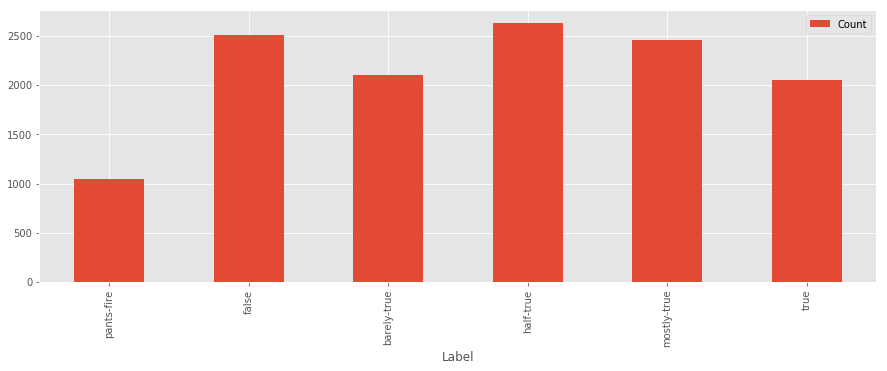

In [19]:
label_distribution = liar_df.groupby("Label").count()
label_distribution = label_distribution[["ID"]]
label_distribution.columns = ["Count"]
label_distribution = label_distribution.transpose()[['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']].transpose()
ax = label_distribution.plot(kind='bar', figsize = (15, 5))
#label_distribution

* and the politifact database :

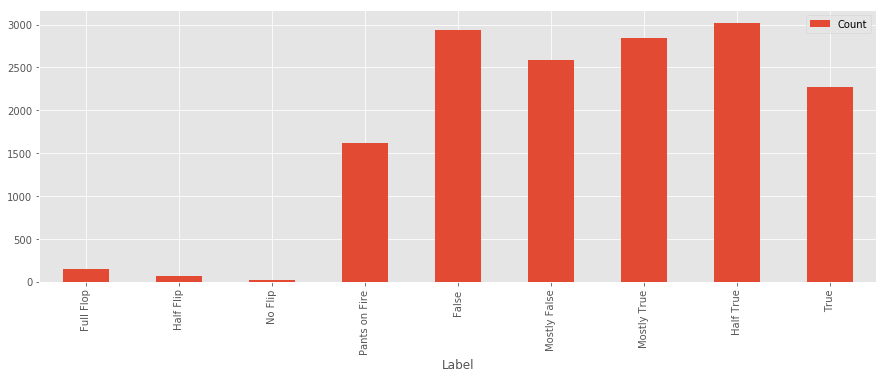

In [20]:
label_distribution = politifact_df.groupby("Label").count()
label_distribution = label_distribution[["Date"]]
label_distribution.columns = ["Count"]
label_distribution = label_distribution.transpose()[['Full Flop', 'Half Flip', 'No Flip', 'Pants on Fire', 'False', 'Mostly False', 'Mostly True', 'Half True','True']].transpose()
ax = label_distribution.plot(kind='bar', figsize = (15, 5))
#label_distribution

The politifact database have three more truth category that all are different type of false statement. They can therefore be considered as `Pants on Fire` or `False` statement.

------

All of the results and interpretation we can have from this dataset depend on its method of data collection. More precisely, the dataset has been constructed from differents sources of media. This selection can be biased. To lower the impact of this bias, the authors have make sure to balance the numbers of article extrated between the two american political parties. But this balance can or cannot represent the reality. It can be interesting to check if their sampling can be considered as representative or not.

---
# B) The fake news menace 
## <font color=#303030> Some time analysis</font>
In this part we will study some evolution of the data over time. Every statement have a date associated. The day information has been croped to regroup every statement of the same month.

It can be intersting to seen what is the time span of our data :

In [21]:
time_span = liar_df.loc[liar_df.shape[0]-1, 'statement_date'] - liar_df.loc[0, 'statement_date']
print(time_span)

7925 days 00:00:00


In [22]:
liar_df['statement_date'] = liar_df['statement_date'].dt.to_period('M')

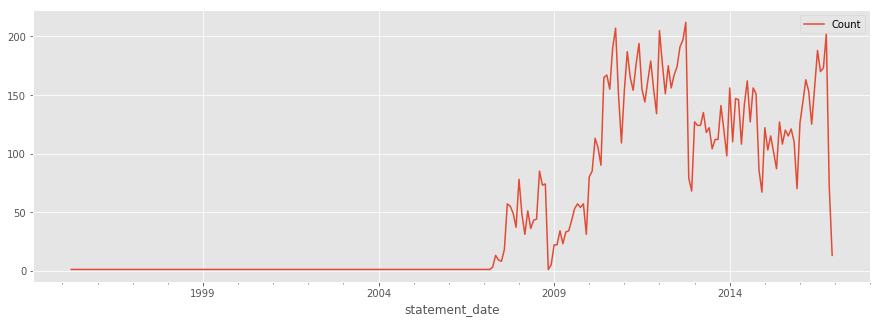

In [23]:
count_time = liar_df.groupby('statement_date').count()[['ID']]
count_time.columns = ['Count']
#count_time = count_time[datetime.datetime(2010, 1, 1):]
count_time.plot(figsize=(15, 5))

The time span is very large due to some outliers. The politifact contributors can choose any article to review which explain the 1995 datapoint.

As the number of point increase since 2009, we will focus more when the number of datapoint is more constant after 2010.

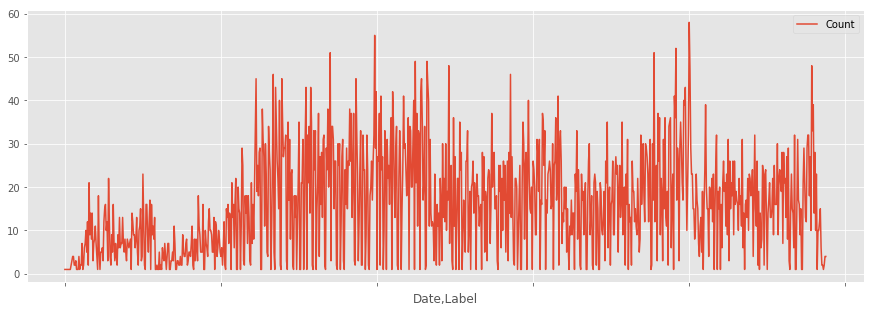

In [24]:
count_time = politifact_df.groupby(['Date','Label']).count()[['Subject']]
count_time.columns = ['Count']
#count_time = count_time[datetime.datetime(2010, 1, 1):]
count_time.plot(figsize=(15, 5))

The same observation can be made on the politifact data. We just have more data and more density.

Then we can compute the evolution of the percentage of false information.

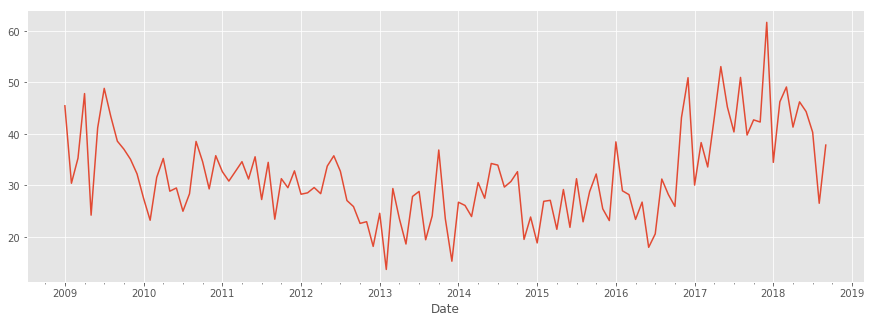

In [25]:
false_db = politifact_df.groupby(['Date','Label']).count()[['Subject']]
false_db = false_db.unstack('Label')
false_db = false_db.fillna(0)
false_db = false_db[[('Subject', 'Full Flop'),
('Subject', 'Half Flip'),
('Subject', 'No Flip'),
('Subject', 'Pants on Fire'),
('Subject', 'False'),
('Subject', 'Mostly False'),
('Subject', 'Mostly True'),
('Subject', 'Half True'),
('Subject', 'True')]]
false_db = false_db[datetime.datetime(2009, 1, 1):datetime.datetime(2018, 9, 1)]
false_db = false_db.div(false_db.sum(axis = 1),axis = 'index')
false_db['False'] = false_db[[
('Subject', 'Full Flop'),
('Subject', 'Half Flip'),
('Subject', 'No Flip'),
('Subject', 'Pants on Fire'),
('Subject', 'False')]].sum(axis = 1)*100
false_db['False'].plot(figsize=(15, 5))

It can be noted that there does not seem to be a clear increase in the number of fake news in the time domain of the database. It is important to note that the number of false information is on average 50% of the total information. The false and the true are in a constant battle. Since 2017, when Donald Trump came into power, falsification of information seems to be gaining ground on its opponent, which can be worrying.

Then we can be interested by looking at this evolution across the two major political parties of USA : the republican and the democrate to see if there is any difference between the two.

In [26]:
republican = politifact_df[politifact_df["Political Party"]=="Republican"]
democrat = politifact_df[politifact_df["Political Party"]=="Democrat"]

In [27]:
rep_false_db = republican.groupby(['Date','Label']).count()[['Subject']]
rep_false_db = rep_false_db.unstack('Label')
rep_false_db = rep_false_db.fillna(0)
rep_false_db = rep_false_db[[('Subject', 'Full Flop'),('Subject', 'Half Flip'),('Subject', 'No Flip'),('Subject', 'Pants on Fire'),('Subject', 'False'),('Subject', 'Mostly False'),('Subject', 'Mostly True'),('Subject', 'Half True'),('Subject', 'True')]]
rep_false_db = rep_false_db[datetime.datetime(2009, 1, 1):datetime.datetime(2018, 9, 1)]
rep_false_db = rep_false_db.div(rep_false_db.sum(axis = 1),axis = 'index')
rep_false_db['Republican'] = rep_false_db[[('Subject', 'Full Flop'),('Subject', 'Half Flip'),('Subject', 'No Flip'),('Subject', 'Pants on Fire'),('Subject', 'False')]].sum(axis = 1)*100


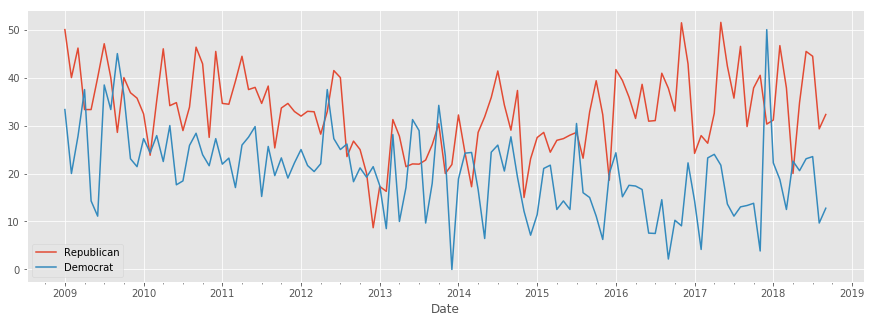

In [28]:
dem_false_db = democrat.groupby(['Date','Label']).count()[['Subject']]
dem_false_db = dem_false_db.unstack('Label')
dem_false_db = dem_false_db.fillna(0)
dem_false_db = dem_false_db[[('Subject', 'Full Flop'),('Subject', 'Half Flip'),('Subject', 'No Flip'),('Subject', 'Pants on Fire'),('Subject', 'False'),('Subject', 'Mostly False'),('Subject', 'Mostly True'),('Subject', 'Half True'),('Subject', 'True')]]
dem_false_db = dem_false_db[datetime.datetime(2009, 1, 1):datetime.datetime(2018, 9, 1)]
dem_false_db = dem_false_db.div(dem_false_db.sum(axis = 1),axis = 'index')
dem_false_db['Democrat'] = dem_false_db[[('Subject', 'Full Flop'),('Subject', 'Half Flip'),('Subject', 'No Flip'),('Subject', 'Pants on Fire'),('Subject', 'False')]].sum(axis = 1)*100

rep_false_db['Republican'].plot(figsize=(15, 5), legend = True)
dem_false_db['Democrat'].plot(figsize=(15, 5), legend = True)

In [29]:
rep_dem = rep_false_db[['Republican']].join(dem_false_db[['Democrat']])
rep_dem = rep_dem.fillna(0)
#rep_dem.to_csv("RepDem.csv")

We can observe that the lie rate of both American parties is generally constant. It must be said that the Republican Party produces much more lies than the Democratic Party. This is espetially true since 2016 and the Donald Trump election.

---
## <font color=#303030>Some interesting distributions</font> 
In this section, we will study the distributions of truth according to some interesting parameters or features.

These two functions get the projection of the truth distribution across the chosen feature, for the two datasets

In [30]:
def get_truth_distribution(data, col_name, count_threshold, normalize = True):
    '''
    Return the distribution of truth outcomes for values of a particular column.
    Input:
        data:           input dataset
        col_name:       column of the dataset
        count_treshold: minimum number of statements for each column value
        normalize:      whether to normalize number of statements per value
    Output:
        For each popular enough value, return its distribution of truthfulness
    '''
    df = data[[col_name, "ID", "Label"]]
    df.columns = [col_name, "Percent", "Label"]
    col_subject = df.groupby([col_name, "Label"]).count()[["Percent"]]
    col_subject = col_subject.unstack('Label')
    col_subject = col_subject.fillna(0)
    col_subject = col_subject[[('Percent', 'pants-fire'),
                               ('Percent', 'false'),
                               ('Percent', 'barely-true'),
                               ('Percent', 'half-true'),
                               ('Percent', 'mostly-true'),
                               ('Percent', 'true')]]
    col_subject = col_subject[col_subject.sum(axis = 1) >= count_threshold]
    if normalize == True:
        col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')
    col_subject = col_subject.sort_values(by=[('Percent', 'pants-fire')], ascending = False)
    return col_subject

In [31]:
def get_truth_distribution_2(data, col_name, count_threshold, normalize = True):
    '''
    Return the distribution of truth outcomes for values of a particular column.
    Input:
        data:           input dataset
        col_name:       column of the dataset
        count_treshold: minimum number of statements for each column value
        normalize:      whether to normalize number of statements per value
    Output:
        For each popular enough value, return its distribution of truthfulness
    '''
    df = data[[col_name, "Date", "Label"]]
    df.columns = [col_name, "Percent", "Label"]
    col_subject = df.groupby([col_name, "Label"]).count()[["Percent"]]
    col_subject = col_subject.unstack('Label')
    col_subject = col_subject.fillna(0)
    col_subject = col_subject[[('Percent', 'Full Flop'),
                                ('Percent', 'Half Flip'),
                                ('Percent', 'No Flip'),
                                ('Percent', 'Pants on Fire'),
                                ('Percent', 'False'),
                                ('Percent', 'Mostly False'),
                                ('Percent', 'Mostly True'),
                                ('Percent', 'Half True'),
                                ('Percent', 'True')]]
  
    col_subject = col_subject[col_subject.sum(axis = 1) >= count_threshold]
    if normalize == True:
        col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')*100
        
    col_subject = col_subject.sort_values(by=[('Percent', 'False')], ascending = False)
    return col_subject

We now want to study which labels are most often reported by subject. To do this, we first check that the labels indicated in the Readme file of the initial database are those found after the import of the database.

In [32]:
liar_df['Label'].unique()

array(['false', 'barely-true', 'mostly-true', 'half-true', 'true',
       'pants-fire'], dtype=object)

This is indeed the case. Since we are examining subjects, we should split rows containing lists of them in individual ones.

In [33]:
print("{} rows expanded to {}".format(len(liar_df),len(split_liar_df)))

12791 rows expanded to 27683


In [34]:
subject_distribution = get_truth_distribution(split_liar_df, "Subject", 700)

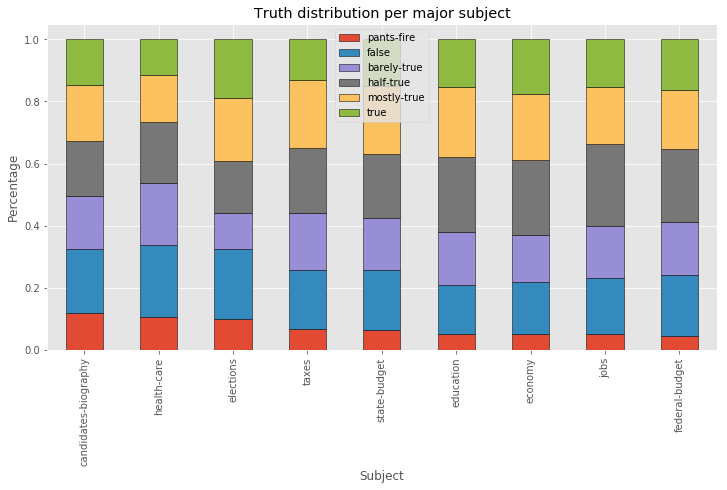

In [35]:
ax = subject_distribution.plot(kind='bar',
                          stacked=True,
                          ec='black',
                          figsize=(12,6)
                         )
plt.title('Truth distribution per major subject')
plt.xlabel('Subject')
plt.ylabel('Percentage')
ax.legend(subject_distribution.columns.get_level_values(1).tolist())

We can see that the health sector is the most affected by the spread of false news here. While keeping in mind the possible biases of the analysis, it is not surprising to find this theme in the foreground. Indeed, all American citizens are concerned by this particular subject and it is no secret that health costs are a major topic of debate in the United States. In order to win public opinion, or to try to discredit its competitors, this seems to be a privileged subject, just like immigration policies.

---
### <font color=#303030>  What are the preferred formats for which topics?</font>

We would now like to study which are the preferred dissemination formats according to the subject of study. The results presented here are only a rough outline of what they will be in the future, as a finer breakdown of topics must be done for interventions that contain several of them.

### <font color=#856514>  What is the preferred context to lie? </font>

In [36]:
context_distribution = get_truth_distribution(liar_df, "Context", 100) 
context_distribution

Percent                                              \
Label             pants-fire     false barely-true half-true mostly-true   
Context                                                                    
a tweet             0.115789  0.200000    0.152632  0.142105    0.247368   
a television ad     0.099379  0.136646    0.254658  0.298137    0.149068   
a news release      0.087379  0.190939    0.200647  0.194175    0.161812   
a radio interview   0.087302  0.222222    0.150794  0.198413    0.166667   
a TV ad             0.063063  0.175676    0.211712  0.243243    0.198198   
a campaign ad       0.060976  0.134146    0.341463  0.250000    0.128049   
an interview        0.048951  0.237762    0.146853  0.206294    0.223776   
a press release     0.046099  0.170213    0.166667  0.209220    0.212766   
a debate            0.043860  0.210526    0.184211  0.210526    0.175439   
a speech            0.030888  0.162162    0.108108  0.243243    0.231660   
a news conference   0.018692  0.224299    0.121495  0.158879    0.214953   

                             
Label                  true  
Context                      
a tweet            0.142105  
a television ad    0.062112  
a news release     0.165049  
a radio interview  0.174603  
a TV ad            0.108108  
a campaign ad      0.085366  
an interview       0.136364  
a press release    0.195035  
a debate           0.175439  
a speech           0.223938  
a news conference  0.261682

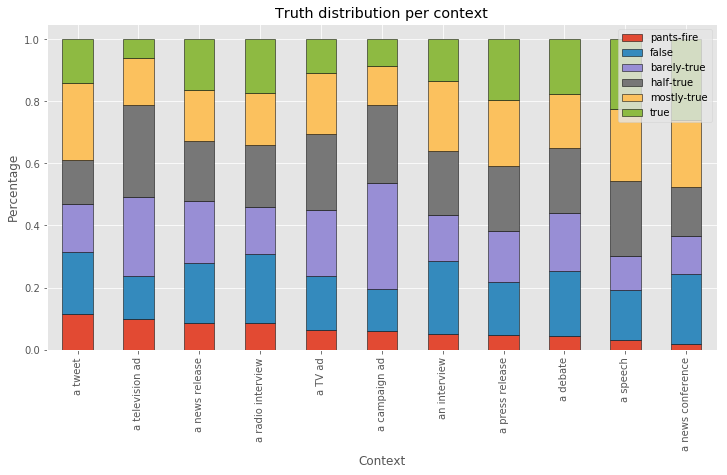

In [37]:
plt.style.use('ggplot')
ax = context_distribution.plot(
    kind='bar',
    stacked=True,
    ec='black',
    figsize=(12,6))
plt.title('Truth distribution per context')
plt.xlabel('Context')
plt.ylabel('Percentage')
ax.legend(context_distribution.columns.get_level_values(1).tolist())

**Note**: *Context* field describes similar types of events in different textual ways. For example there are both `an interview` and `an interview in CNN`. We aim to apply preprocessing, possibly using NLP, to distinguish between them more strictly and update the respective plots.

### <font color=#856514>  Are statements in debates more likely to be lies, compared to other speeches? </font> 

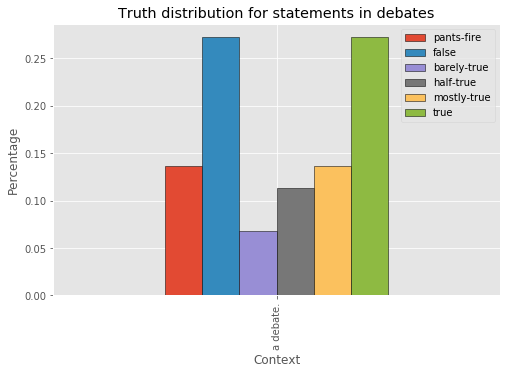

In [38]:
debate = liar_df[liar_df["Context"] == "a debate."]
debate_distribution = get_truth_distribution(debate, "Context", 10)

plt.style.use('ggplot')
groups = debate_distribution.columns.get_level_values(1).tolist()
ind = np.arange(len(groups))  # the x locations for the groups
ax = debate_distribution.plot(width=0.5,
                              kind='bar',
                              ec='black',
                              figsize=(8,5))

plt.title('Truth distribution for statements in debates')
plt.ylabel('Percentage')

ax.legend(groups)

It seems that the debate are quite polarised in truth distribution. Debaters either say completely true or completely false information. The goal in a broadcasted debate is not to find the best solution to a problem but to win the debate by getting most agreement from the audience. Very polarised ideas and false information are intentionaly used because there is no possible immediate fact checking.

### <font color=#856514>  What is the preferred format for each topic? </font> 

### <font color=#856514> Compare distribution of fake news between traditional press, speeches and social media </font> 

The Internet and social networks seem to represent an ideal platform for the spread of false news, as they are anonymous, free and widely available. We would like to compare the distribution of labels assigned to news between traditional media and those from the Internet.

In [39]:
context_distribution = get_truth_distribution(liar_df, "Context", 70, normalize = True) 
context_distribution.head()

Percent                                              \
Label             pants-fire     false barely-true half-true mostly-true   
Context                                                                    
a Facebook post     0.160920  0.206897    0.206897  0.195402    0.149425   
a tweet             0.115789  0.200000    0.152632  0.142105    0.247368   
a television ad     0.099379  0.136646    0.254658  0.298137    0.149068   
a news release      0.087379  0.190939    0.200647  0.194175    0.161812   
a radio interview   0.087302  0.222222    0.150794  0.198413    0.166667   

                             
Label                  true  
Context                      
a Facebook post    0.080460  
a tweet            0.142105  
a television ad    0.062112  
a news release     0.165049  
a radio interview  0.174603

**Traditional press:**

/Users/Moi/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


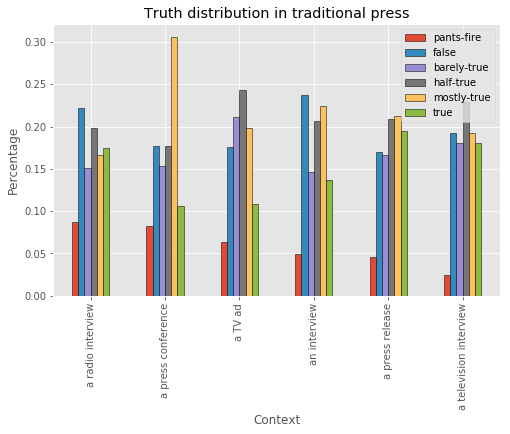

In [40]:
traditional_press_regex = re.compile(r'\b(ABC|TV|CNN|MSNBC|radio|interview|newspaper|press)[s]*\b' ,re.I)
traditional_press_sets = context_distribution[context_distribution.index.str.contains(traditional_press_regex, regex=True) == True]

plt.style.use('ggplot')
groups = traditional_press_sets.columns.get_level_values(1).tolist()
ind = np.arange(len(groups))  # the x locations for the groups
ax = traditional_press_sets.plot(width=0.5,
                              kind='bar',
                              ec='black',
                              figsize=(8,5))

plt.title('Truth distribution in traditional press')
plt.ylabel('Percentage')

ax.legend(groups)

**Social media:**

/Users/Moi/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


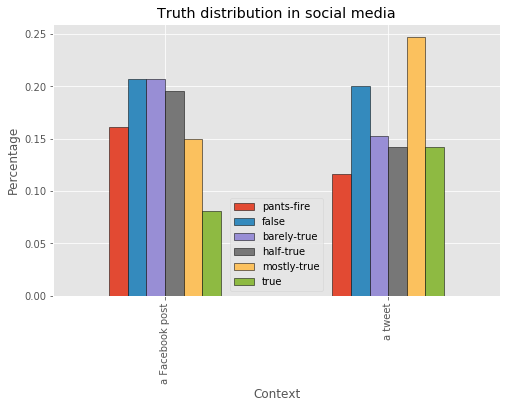

In [41]:
social_media_regex = re.compile(r'\b(Facebook|blog|twitter|my space|newsletter|video|email|tweet|social media|YouTube)[s]*\b' ,re.I)
social_media_sets = context_distribution[context_distribution.index.str.contains(social_media_regex, regex=True) == True]
plt.style.use('ggplot')
groups = social_media_sets.columns.get_level_values(1).tolist()
ind = np.arange(len(groups))  # the x locations for the groups
ax = social_media_sets.plot(width=0.5,
                              kind='bar',
                              ec='black',
                              figsize=(8,5))

plt.title('Truth distribution in social media')
plt.ylabel('Percentage')

ax.legend(groups)

**Speeches:**

/Users/Moi/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


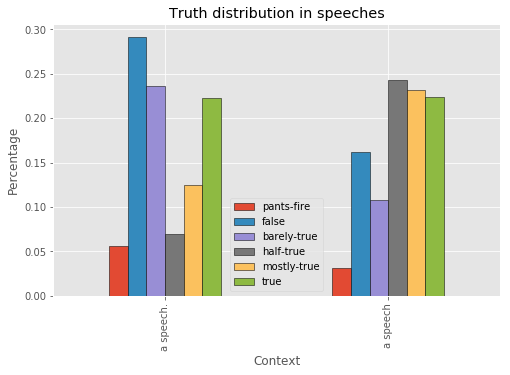

In [42]:
speech_regex = re.compile(r'\b(speech)[s]*\b' ,re.I)
speech_sets = context_distribution[context_distribution.index.str.contains(speech_regex, regex=True) == True]
plt.style.use('ggplot')
groups = speech_sets.columns.get_level_values(1).tolist()
ind = np.arange(len(groups))  # the x locations for the groups
ax = speech_sets.plot(width=0.5,
                              kind='bar',
                              ec='black',
                              figsize=(8,5))

plt.title('Truth distribution in speeches')
plt.ylabel('Percentage')

ax.legend(groups)

---
### <font color=#303030> What are the most prominent professions among the liars?</font> 

From now on, we would like to know which professions are most often reported as liars. Before that, we study the distribution of the categorization of reported news according to the profession of their propagator.

### <font color=#856514> Professions truth distribution ? </font> 

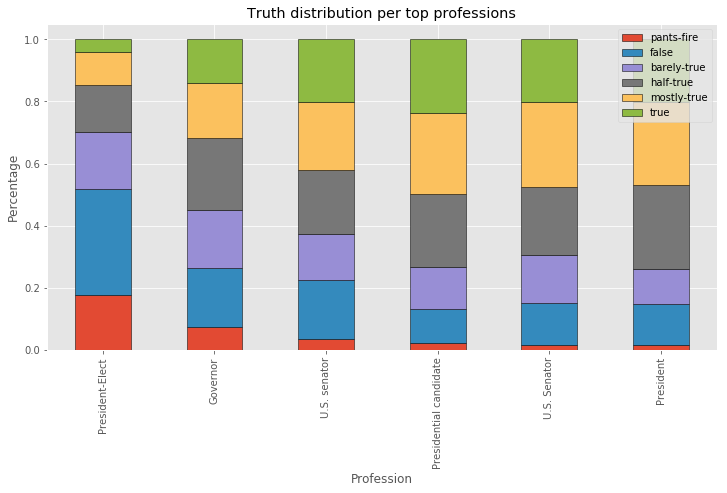

In [43]:
profession_distribution = get_truth_distribution(liar_df, "Job title", 300) 
plt.style.use('ggplot')
ax = profession_distribution.plot(kind='bar',
                                                     stacked=True,
                                                     ec='black',
                                                     figsize=(12,6))
plt.title('Truth distribution per top professions')
plt.xlabel('Profession')
plt.ylabel('Percentage')
ax.legend(profession_distribution.columns.get_level_values(1).tolist())

### <font color=#856514>  What are the most prominent professions in the dataset ? </font> 

In [44]:
jobs = liar_df.groupby("Job title").count()
jobs = jobs.sort_values(by=['ID'], ascending = False)
jobs = jobs[["ID"]]
jobs.head()

,ID
Job title,
President,615
U.S. Senator,595
Governor,487
President-Elect,343
U.S. senator,328


### <font color=#856514> And among the liars ? </font> 

For each Statement, we can access the job title of the speaker. That way, we can access the most frequent jobs in the liar groups for this specific dataset.

In [45]:
lie = liar_df[liar_df['Label'] == 'false']
jobs_lie = lie.groupby("Job title").count()
jobs_lie = jobs_lie[["ID"]]

In [46]:
jobs_lie = jobs_lie.sort_values(by=['ID'], ascending = False)
jobs_lie.head()

,ID
Job title,
President-Elect,117
Governor,93
President,82
U.S. Senator,80
U.S. senator,62


Because all the jobs don't have the same media coverage, it is more interesting to have the percentage of lie of the job than the raw numbers themselves

In [47]:
jobs_lie = jobs_lie.join(jobs, lsuffix = '_lie', rsuffix = '_total')
jobs_lie["ratio (%)"] =jobs_lie["ID_lie"]/jobs_lie["ID_total"]*100
jobs_lie = jobs_lie.sort_values(by=['ID_total'], ascending = False)
jobs_lie.head(10)

,ID_lie,ID_total,ratio (%)
Job title,,,
President,82,615,13.333333
U.S. Senator,80,595,13.445378
Governor,93,487,19.096509
President-Elect,117,343,34.110787
U.S. senator,62,328,18.902439
Presidential candidate,34,314,10.828025
Former governor,36,212,16.981132
U.S. Representative,32,210,15.238095
Senator,44,193,22.797927


### <font color=#856514>  What about the politics? </font> 

Since politicians are very often the most visible and most influential and those whose message is most widely conveyed, we can study this area more precisely.

The people that have a political message generaly have a party affiliation.

In [48]:
lie_party = lie[lie['Party Affiliations'] != 'none']
lie_party = lie_party.groupby("Job title").count()
lie_party = lie_party[["ID"]].sort_values(by=['ID'], ascending = False)
lie_party.head(2)

,ID
Job title,
President-Elect,117
Governor,93


In [49]:
politics_regex = re.compile(r'\b(mayor|president|council|house|candidate|political|assembly|republican|governor|senator)[s]*\b' ,re.I)
politics_liar_sets = jobs_lie[jobs_lie.index.str.contains(politics_regex, regex=True) == True]
politics_liar_sets.head(2)

/Users/Moi/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


,ID_lie,ID_total,ratio (%)
Job title,,,
President,82,615,13.333333
U.S. Senator,80,595,13.445378


---
### <font color=#303030> Which political parties tend to lie the most?</font> 

In [50]:
col_subject = get_truth_distribution(liar_df, "Party Affiliations", 2,True)

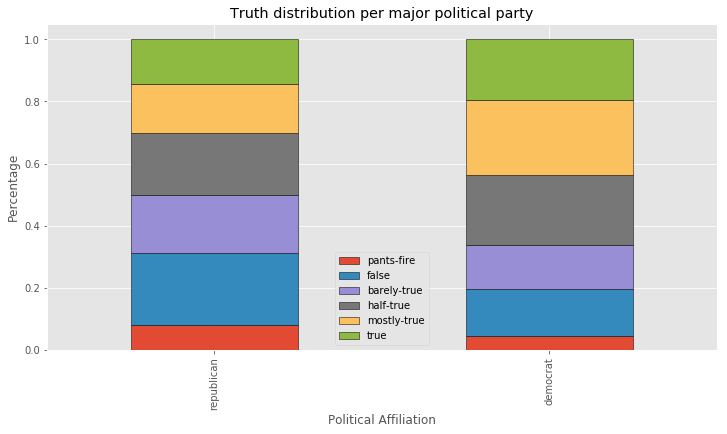

In [51]:
plt.style.use('ggplot')
ax = col_subject.loc[['republican','democrat']].plot(kind='bar',
                                                     stacked=True,
                                                     ec='black',
                                                     figsize=(12,6))
plt.title('Truth distribution per major political party')
plt.xlabel('Political Affiliation')
plt.ylabel('Percentage')
ax.legend(col_subject.columns.get_level_values(1).tolist())

---
# C) The Fake War 

TODO : ADD KONSTANTINOS'S WORK

---
# D) The Revenge of the Liar 
TODO : ADD JEREMY'S WORK
## <font color=#303030> With what vocabulary?</font> 

Now, we would like to visualize which vocabulary is used by each speaker. To do this, we use the BeautifulSoup and WordCloud libraries.

In [52]:
text = open('res/test_plain_text.txt').read() #President Donald Trump's statement to the United Nations General Assembly on Sept. 25, 2018.

trump_mask = np.array(Image.open('res/Trumpy3.png'))
wc = WordCloud(background_color="white", max_words=2000, mask=trump_mask,contour_width=0, contour_color='steelblue')
# generate word cloud
wc.generate(text)

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 385: ordinal not in range(128)

In [ ]:
# show the word cloud
plt.figure(figsize = (30,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

----
----

## <font color=#303030>Our project: what is next?</font> 

### <font color=#856514>  The action plan </font> 

<div class="alert alert-block alert-info"><b>Our plan for the next weeks :</b><br />
<br />
- <b>Objective 1</b>: Expand our preliminary analysis to more detailed answering of the main questions, with careful preprocessing of the data. <br />	
- <b>Objective 2</b>: Find another relevant news dataset and check if our insights can be generalized to different sources. <br />
- <b>Objective 3</b>: Make an interactive visualization to engage the user, selecting between a graph or flow chart.<br />
</div>

### <font color=#856514>   What is in our mind </font> 

### <font color=#856514> The report plan  </font> 

* As we have already pointed out on several occasions, our database is subject to many biases that makes it difficult to generalize our results. Despite the goodwill of Politifact journalists and contributors, the sample presented in these data is certainly not representative of fakes news activity in the United States. While it is useful for classifying new data, it is not useful for drawing conclusions. What we want to do with this work is above all to exercise the skills we learned during the course and extract information from the data available. As we have seen, the relevance of this information must be confirmed through our critical thinking. We would therefore like to find a second dataset and check if our insights can be generalized to statements of different countries, periods and sources, hopefully in an international level. In particular we will to answer the same questions and compare as well as explain the differences in the results.
* Moreover, we will improve our existing analysis and respective plots by processing the numerous text fields with the most generic - possibly NLP assisted - methods, aiming to avoid hard-coded solutions.
* Besides our already implemented visualizations, we would to experiment with more intricate and **interactive** alternatives. In particular we believe a graph would be a good choice as it allows for both a high level overview of the dataset, as well as (for example with selection or zooming) a more fine-grained view between a pair of specific nodes. We will evaluate the possible semantics of nodes, edges and design a functioning prototype using frameworks like D3.js. Another option we are considering is a Streamgraph. This particular type of visualization is ideal for discovering patterns over time and would be ideal to present the rise of fake news before important events like elections.

We propose this data story plan :
* **A) Introduction :**
    Where we introduce our goals and present our data
* **B) The fake news menace :**
    In this section, we will study the rise of the fake news over time and some interesting distribution properties.
* **C) The fake war :**
    In this section, we will study the relationship between liars and the subject they like to lie about
* **D) The revenge of the liar :**
    In this section, we will study famous politician and understand where they lie and about what they lie. 

The data story can be found in the following [link](https://nicolasfontbonne.github.io)